<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder

!pip install subgroups

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
#Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""


vector_space_dimention = 36
n_clusters = 23
max_depth = 3
test_size = 0.2
mixed_threshold = 0.9


In [3]:
#Data augemntation

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mapping_targets = {'p': 'poisonous', 'e': 'edible'}

data = fetch_ucirepo(id=73)
features_raw = preprocess_mushroom_data(pd.DataFrame(data=data.data.features))
target_df = pd.DataFrame(data=data.data.targets)
target_df.columns = ['class']
target_df['class'] = target_df['class'].map(mapping_targets)


In [4]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

In [5]:
#Word2Vec training and clustering
def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_agglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [6]:
#Classification trees training
features_classify = features_raw.assign(cluster=labels_agglomerative_average)

encoder = OneHotEncoder()
X = features_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(X)
y = features_classify['cluster']
X_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=test_size, random_state=73, stratify=y)

decision_trees = {}
accuracies = {}

for cluster in sorted(y.unique()):
    # print(f"Training Decision Tree for Cluster {cluster}...")

    y_train_binary = (y_train == cluster).astype(int)
    y_test_binary = (y_test == cluster).astype(int)

    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=73)
    clf.fit(X_train, y_train_binary)

    decision_trees[cluster] = clf

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test_binary, y_pred)
    accuracies[cluster] = accuracy

    print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
    print(classification_report(y_test_binary, y_pred))


Accuracy for Cluster 0: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1619
           1       1.00      1.00      1.00         6

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy for Cluster 1: 0.9969
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1567
           1       1.00      0.91      0.95        58

    accuracy                           1.00      1625
   macro avg       1.00      0.96      0.98      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy for Cluster 2: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1618
           1       1.00      1.00      1.00         7

    accuracy                           1.00      1625
   macro avg       1.00      1.00  

In [7]:
#Subgroup creation
def classify_and_extract_rules(data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees):

    cluster_class_counts = {}
    for i, cluster in enumerate(cluster_labels):
        class_label = target_df['class'][i]
        cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
        cluster_class_counts[cluster][class_label] += 1

    class_counts = {}
    cluster_classifications = {}
    cluster_frequencies = {}
    cluster_percentages = {}
    rules_dict = {}
    unextractable_clusters = []
    tp_dict = {}
    fp_dict = {}
    n_dict = {}
    TP_dict = {}
    FP_dict = {}
    WRAcc_dict = {}
    N = len(target_df)


    for class_ in set(target_df['class']):
        class_counts[class_] = sum(target_df['class'] == class_)

    for cluster, class_counts in sorted(cluster_class_counts.items()):
        total_count = sum(class_counts.values())
        class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}

        dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
        relative_frequency = dominant_count / total_count
        classification = dominant_class if relative_frequency >= mixed_threshold else 'mixed'

        cluster_classifications[cluster] = classification
        cluster_frequencies[cluster] = total_count
        cluster_percentages[cluster] = class_percentages
        tp_dict[cluster] = dominant_count
        fp_dict[cluster] = total_count - dominant_count
        n_dict[cluster] = total_count
        if cluster_classifications == 'mixed':
            TP_dict[cluster] = np.NaN
            FP_dict[cluster] = np.NaN
        else:
            TP_dict[cluster] = class_counts[dominant_class]
            FP_dict[cluster] = N - class_counts[dominant_class]
        WRAcc_dict[cluster] = ((tp_dict[cluster]+fp_dict[cluster]) / N) * (tp_dict[cluster] / n_dict[cluster] - TP_dict[cluster] / N)

        if cluster in decision_trees:
            rules_list = extract_rules_from_tree(decision_trees[cluster], feature_names)
            if rules_list:
                rules_dict[cluster] = rules_list
            else:
                unextractable_clusters.append(cluster)
        else:
            unextractable_clusters.append(cluster)
    return cluster_frequencies, cluster_percentages, rules_dict, unextractable_clusters, WRAcc_dict

def extract_rules_from_tree(tree, feature_names, node=0, rule_list=None, rule_path=None):

    if rule_list is None:
        rule_list = []
    if rule_path is None:
        rule_path = []

    left_child = tree.tree_.children_left[node]
    right_child = tree.tree_.children_right[node]
    threshold = tree.tree_.threshold[node]
    feature = tree.tree_.feature[node]
    value = tree.tree_.value[node]

    if left_child == -1 and right_child == -1:
        class_probabilities = value[0] / value.sum()
        predicted_class = class_probabilities.argmax()
        if predicted_class == 1:
            rule_list.append(" AND ".join(rule_path))
        return rule_list

    if left_child != -1:
        extract_rules_from_tree(tree, feature_names, left_child, rule_list, rule_path + [f"{feature_names[feature]} <= {threshold:.2f}"])

    if right_child != -1:
        extract_rules_from_tree(tree, feature_names, right_child, rule_list, rule_path + [f"{feature_names[feature]} > {threshold:.2f}"])

    return rule_list

cluster_frequencies, cluster_percentages, rules_dict, unextractable_clusters, WRAcc_dict = classify_and_extract_rules(
    data_frame=features_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels_agglomerative_average,
    feature_names=list(X_df.columns),
    decision_trees=decision_trees
)



print("\nFormatted Cluster Summary:")
for cluster in sorted(cluster_frequencies.keys()):
    percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in cluster_percentages[cluster].items())
    rules = rules_dict.get(cluster, ["No rules extracted"])

    print(f"Cluster {cluster}: support = {cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {WRAcc_dict[cluster]}")
    for rule in rules:
        print(f"  - {rule}")

print("\nUnextractable Clusters:", unextractable_clusters)



Formatted Cluster Summary:
Cluster 0: support = 32, 'poisonous': 1.0, WRAcc = 0.0039234310336509854
  - stalk-color-below-ring_yellow <= 0.50 AND stalk-surface-below-ring_scaly > 0.50 AND ring-type_evanescent > 0.50
  - stalk-color-below-ring_yellow > 0.50 AND stalk-root_nan > 0.50
Cluster 1: support = 288, 'edible': 0.33, 'poisonous': 0.67, WRAcc = 0.022795851888054216
  - odor_creosote <= 0.50 AND cap-shape_sunken > 0.50
  - odor_creosote > 0.50
Cluster 2: support = 36, 'poisonous': 1.0, WRAcc = 0.004411678074047246
  - stalk-color-above-ring_cinnamon > 0.50
Cluster 3: support = 288, 'poisonous': 1.0, WRAcc = 0.03419377783208132
  - cap-color_buff <= 0.50 AND habitat_urban > 0.50 AND stalk-root_bulbous > 0.50
  - cap-color_buff > 0.50 AND spore-print-color_chocolate > 0.50
Cluster 4: support = 8, 'poisonous': 1.0, WRAcc = 0.0009837668768262295
  - stalk-color-above-ring_yellow > 0.50
Cluster 5: support = 192, 'edible': 1.0, WRAcc = 0.0230751272557486
  - stalk-root_rooted > 0.50
Clu

In [8]:
#Cluster metrics
support = sum(cluster_frequencies.values())/len(features_df)*100
print(f"Overall support of describable subgroups is {support:.2f}%") #Subgroups can be undescribable if they are too small and decission tree cant find the rules for characterization
#Entropy, serendipity TBD - dont know how to do it at the moment

Overall support of describable subgroups is 100.00%


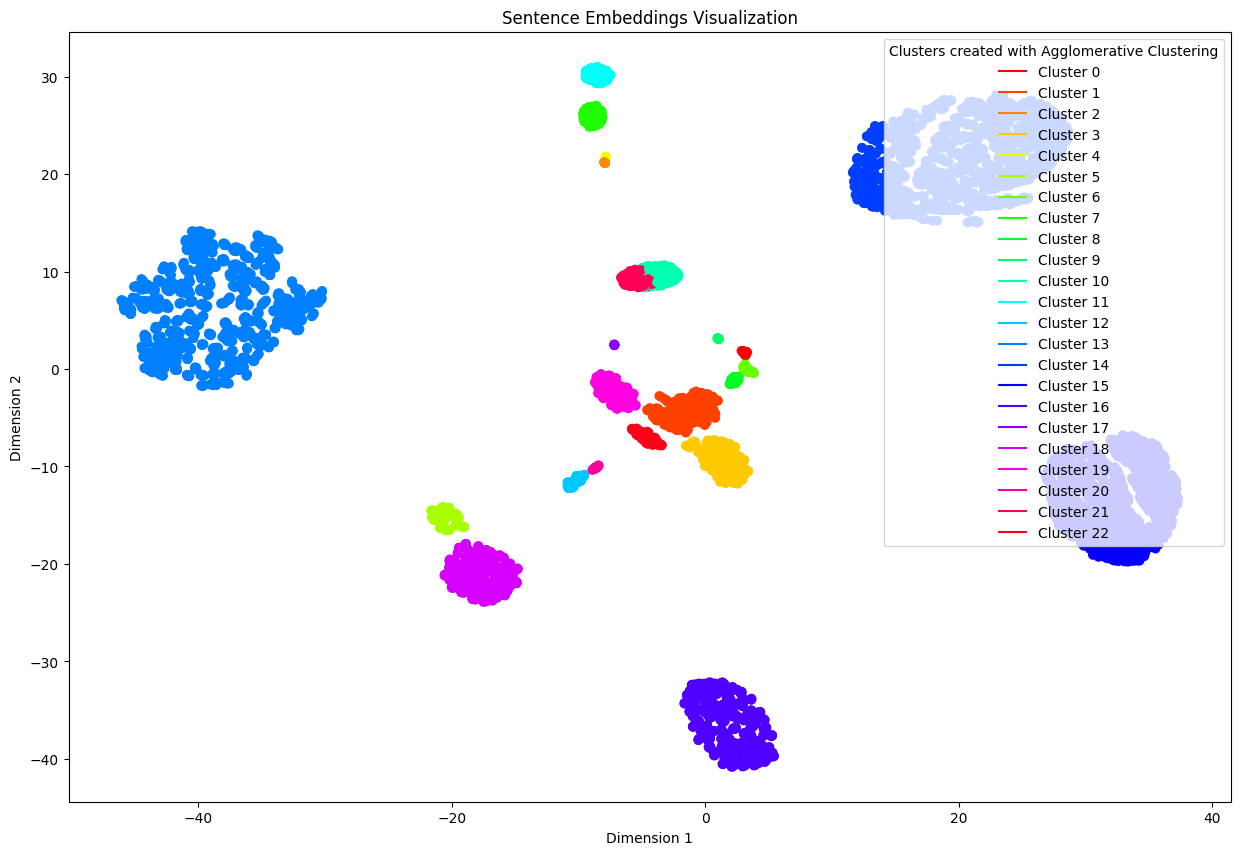

In [9]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_agglomerative_average, clustering_method='Agglomerative Clustering')

In [17]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('class', 'edible')

bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=23, max_depth=4, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


CPU times: user 2min 9s, sys: 1.63 s, total: 2min 11s
Wall time: 2min 12s


In [18]:
import re
import os

def extract_wracc_from_file(file_path):
    subgroups = []

    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = re.search(r"Description: (.*?);.*?WRAcc\s*=\s*([+-]?\d*\.?\d+)", line)
            if match:
                description = match.group(1).strip()
                try:
                    wracc = float(match.group(2))
                    subgroups.append((description, wracc))
                except ValueError:
                    print(f"Warning: Could not convert WRAcc value '{match.group(2)}' to float.")

    if not subgroups:
        print("Warning: No valid WRAcc values found in file.")

    return subgroups

def find_top_subgroups(file_path, top_n=1):
    subgroups = extract_wracc_from_file(file_path)
    sorted_subgroups = sorted(subgroups, key=lambda x: x[1], reverse=True)
    return sorted_subgroups[:top_n] if subgroups else []

file_path = "./results_BSD.txt"

top_subgroups = find_top_subgroups(file_path, top_n=90)

if top_subgroups:
    for desc, wracc in top_subgroups:
        print(f"Subgroup: {desc}, WRAcc: {wracc}")
else:
    print("No valid subgroups found.")


Subgroup: [odor = 'none'], Target: class = 'edible', WRAcc: 0.19455893037534175
Subgroup: [gill-size = 'broad', stalk-surface-above-ring = 'smooth'], Target: class = 'edible', WRAcc: 0.18653946061550644
Subgroup: [gill-size = 'broad', odor = 'none'], Target: class = 'edible', WRAcc: 0.18622721523912592
Subgroup: [odor = 'none', veil-color = 'white'], Target: class = 'edible', WRAcc: 0.183676888096639
Subgroup: [gill-size = 'broad', stalk-surface-below-ring = 'smooth'], Target: class = 'edible', WRAcc: 0.17514735290830633
Subgroup: [gill-size = 'broad', ring-number = 'one', stalk-surface-above-ring = 'smooth'], Target: class = 'edible', WRAcc: 0.16929517636651595
Subgroup: [odor = 'none', ring-number = 'one'], Target: class = 'edible', WRAcc: 0.16782122303701782
Subgroup: [gill-size = 'broad', stalk-surface-above-ring = 'smooth', stalk-surface-below-ring = 'smooth'], Target: class = 'edible', WRAcc: 0.16407379366738256
Subgroup: [odor = 'none', stalk-surface-above-ring = 'smooth'], Targ